In [0]:
# !pip install pyamg

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize 
import io, csv, os
import numpy as np
from collections import defaultdict
import pickle
import scipy
import sklearn.metrics

In [0]:
import itertools
from multiprocessing import Pool #  Process pool
from multiprocessing import sharedctypes

In [0]:
base_path = "/content/drive/My Drive/Q3 Spring 20/ML/modeling/spectral-clustering/"

In [0]:
os.makedirs(base_path + '/obj/', exist_ok=True)
def save_obj(obj, name ):
    with open( base_path + '/obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(base_path + '/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
raw_df = pd.read_csv( base_path + "train.csv")
raw_df.head(2)

,movie-id,customer-id,rating,date
0,1262,24294,4,2004-07-04
1,1810,18187,3,2004-03-12


In [0]:
from sklearn.utils import shuffle
raw_df = shuffle(raw_df)
raw_df = raw_df.reset_index(drop=True)

In [0]:
split_index = round(0.0 * raw_df.shape[0])
train_df = raw_df[split_index: ]
validate_df = raw_df[: split_index]

In [7]:
print(train_df.shape, validate_df.shape)

(1000000, 4) (0, 4)


In [0]:
train_customers = train_df['customer-id']
train_cid_sorted = train_customers.sort_values()
train_movies = train_df['movie-id']
train_mid_sorted = train_movies.sort_values()

In [9]:
train_cid = {}
cursor = 0
for val in train_cid_sorted:
    if val not in train_cid:
        train_cid[val] = cursor
        cursor += 1
print(len(train_cid))

5905


In [10]:
train_mid = {}
cursor = 0
for val in train_mid_sorted:
    if val not in train_mid:
        train_mid[val] = cursor
        cursor += 1
print(len(train_mid))

16142


In [11]:
train_movies_n = len(train_mid)
train_cust_n = len(train_cid)
print(train_movies_n, train_cust_n)

16142 5905


In [12]:
# Make movie-by-user matrix to hold ratings
train_ratings = np.zeros((train_cust_n, train_movies_n), np.short)

for i in range(len(train_df)):
    current = train_df.iloc[i]
    customer_idx = train_cid.get(current[1])
    movie_idx = train_mid.get(current[0])
    train_ratings[customer_idx, movie_idx] = current[2]

train_ratings.shape

(5905, 16142)

In [0]:
save_obj(train_ratings, 'train_ratings_temp')
# train_ratings = load_obj('train_ratings_temp')

In [60]:
train_ratings.shape

(5904, 15888)

In [0]:
train_normalized_mov = np.zeros(train_ratings.shape)

In [0]:
# for i in range(train_ratings.shape[1]):
#     rating_movie = train_ratings[:, i]
#     train_normalized_mov[:, i] = rating_movie - np.mean(rating_movie)

train_normalized_mov = train_ratings.copy()
train_normalized_mov_t = np.transpose(train_normalized_mov)

for i in range(train_normalized_mov_t.shape[0]):
    record = train_normalized_mov_t[i]
    nonzeros = record[np.nonzero(record)]
    if len(nonzeros) > 0:
        mean = np.mean(nonzeros)
    else:
        mean = 0
    record[np.nonzero(record)] = record[np.nonzero(record)] - mean # type 3

    train_normalized_mov_t[i] = record

In [0]:
train_normalized_mov_t = np.transpose(train_normalized_mov)

CLUSTER MOVIES


In [0]:
train_movie_by_movie = sklearn.metrics.pairwise_distances(train_normalized_mov_t, metric='cosine', n_jobs=-1, force_all_finite=True)

In [0]:
train_movie_by_movie = 2 - train_movie_by_movie

In [0]:
for i in range(train_movie_by_movie.shape[0]):  # Remove self-connections
    train_movie_by_movie[i][i] = 0

In [0]:
for i in range(train_movie_by_movie.shape[0]):   
    array_sum = np.sum(train_movie_by_movie[i])
    array_has_nan = np.isnan(array_sum)
    if array_has_nan:
        print('arr has nan:', i)

In [0]:
c1 = train_movie_by_movie.copy()

In [0]:
type(train_movie_by_movie[0][0])

numpy.float64

In [0]:
np.isfinite(train_movie_by_movie).all()

True

In [0]:
spec_clus = SpectralClustering(n_clusters=10, eigen_solver='arpack', random_state=1, 
                   n_init=5, gamma=1.0, affinity='precomputed', assign_labels='kmeans', n_jobs=-1)

In [0]:
cluster_labels = spec_clus.fit_predict(c1)

In [0]:
save_obj(cluster_labels, 'cluster_labels_temp')
# cluster_labels = load_obj('cluster_labels_final')

In [0]:
cluster_labels_copy = cluster_labels.copy()

In [0]:
label_map = defaultdict(set)
for i, label in enumerate(cluster_labels):
    label_map[label].add(i)

In [24]:
for label in label_map:
    print(len(label_map[label]))

796
7672
1990
1045
749
2350
459
604
335
142


In [0]:
# save_obj(label_map, "label_map_mbym")
label_map = load_obj('label_map_mbym')

In [0]:
 for label in label_map:
    print(label)

4
5
6
9
0
7
1
8
3
2


In [0]:
label_map[4]

{4668, 4827, 6834, 8803, 14024, 14958}

In [0]:
cosine_similarity = 1 - scipy.spatial.distance.cosine(train_normalized_mov_t[0], train_normalized_mov_t[1])
print(cosine_similarity)

-0.0005541861454665398


In [0]:
validate_df = test_df

In [29]:
size = validate_df.shape[0]
block_size = 10000

result = np.ctypeslib.as_ctypes(np.zeros((size, 3)))
shared_array = sharedctypes.RawArray(result._type_, result)

def fill_per_window(args):
    window_x, _ = args
    tmp = np.ctypeslib.as_array(shared_array)

    for i in range(window_x, window_x + block_size):
        record = validate_df.iloc[i]
        cid = train_cid.get(record[1])
        mid = train_mid.get(record[0])

        if mid is not None:
            if cid is not None:
                cluster_id = cluster_labels[mid]
                neighbours = []
                cluster_set = label_map.get(cluster_id)
                for j in cluster_set:
                    if j != mid and train_ratings[cid][j] != 0:
                        similarity = train_movie_by_movie[j][mid]
                        neighbours.append([j, similarity, train_ratings[cid][j]])

                # try:    
                if len(neighbours) > 10:    
                    neighbours.sort(key = lambda x: x[1])
                    l = len(neighbours)
                    nearest_neighbours = np.array(neighbours[l-10:])
                    nn_ratings = nearest_neighbours[:, 2]
                    nn_weight = nearest_neighbours[:, 1]
                    rating_prediction = np.average(nn_ratings, weights=nn_weight)
                else:
                    if len(neighbours) > 1:
                        movie_r = np.array(neighbours)[:, 2]
                        nonzeros = movie_r[np.nonzero(movie_r)]
                        rating_prediction = np.mean(nonzeros)
                    else:
                        movie_r = train_ratings[:, mid]
                        nonzeros = movie_r[np.nonzero(movie_r)]
                        rating_prediction = np.mean(nonzeros)
                # except:
                #     print(record, neighbours)

            else:
                movie_r = train_ratings[:, mid]
                nonzeros = movie_r[np.nonzero(movie_r)]
                rating_prediction = np.mean(nonzeros)
        else:
            if cid is not None:
                movie_r = train_ratings[cid]
                nonzeros = movie_r[np.nonzero(movie_r)]
                rating_prediction = np.mean(nonzeros)
            else:
                rating_prediction = 3

        # pred_record = [record[0], record[1], rating_prediction, round(rating_prediction), record[2]]
        # m_preds.append(pred_record)

        if rating_prediction <= 0.5:
            rating_prediction = 1
        if rating_prediction > 5.5:
            rating_prediction = 5 

        tmp[i][0] = record[0]
        tmp[i][1] = record[1]
        tmp[i][2] = rating_prediction
        # tmp[i][3] = record[2]

    print(window_x + block_size , ' records done')


window_idxs = [(i, 0) for i in range(0, size, block_size)]

p = Pool(10)
res = p.map(fill_per_window, window_idxs)
result = np.ctypeslib.as_array(shared_array)

10000  records done
50000  records done
100000  records done
20000  records done
90000  records done
80000  records done
40000  records done
30000  records done
60000  records done
70000  records done
120000  records done
130000  records done
110000  records done
140000  records done
180000  records done
150000  records done
190000  records done
160000  records done
170000  records done
200000  records done
210000  records done
230000  records done
220000  records done
250000  records done
240000  records done


In [0]:
np.savetxt(base_path + 'pred_final.txt', np.around(result[:, 2]))

In [30]:
# preds_array = np.array(m_preds)
A = np.around(result[:, 2])
B = np.array(validate_df['rating'])  #result[:, 3]
mse = ((A - B)**2).mean(axis=None)

TypeError: ignored

In [33]:
rmse = np.sqrt(mse)
print(mse, rmse)

0.91953 0.9589212689267039


In [34]:
count = 0
for i in range(len(result)):
    # record = result[i]
    if A[i] == B[i]:
        count += 1
count

45058

In [0]:
d = {}

for val in A:
    if val in d:
        d[val] += 1
    else:
        d[val] = 1

In [36]:
d

{1.0: 408, 2.0: 3871, 3.0: 32066, 4.0: 53174, 5.0: 10481}

In [0]:
gtd = {}

for val in B:
    if val in gtd:
        gtd[val] += 1
    else:
        gtd[val] = 1

In [39]:
gtd

{1: 4524, 2: 9800, 3: 28433, 4: 33528, 5: 23715}

though we take rounded integer of the predicted rating... for the purpose of recommending movies.. i think its useful to have the fractions

CLUSTER USERS

In [0]:
train_normalized_cust = np.zeros(train_ratings.shape)

In [0]:
# for i in range(train_ratings.shape[0]):
#     rating_movie = train_ratings[i]
#     train_normalized_cust[i] = rating_movie - np.mean(rating_movie)

train_normalized_cust = train_ratings.copy()

for i in range(train_normalized_cust.shape[0]):
    record = train_normalized_cust[i]
    nonzeros = record[np.nonzero(record)]
    if len(nonzeros) > 0:
        mean = np.mean(nonzeros)
    else:
        mean = 0
    record[np.nonzero(record)] = record[np.nonzero(record)] - mean # type 3

    train_normalized_cust[i] = record

In [0]:
train_cust_by_cust = np.zeros((train_cust_n, train_cust_n))

In [0]:
train_cust_by_cust = sklearn.metrics.pairwise_distances(train_normalized_cust, metric='cosine', n_jobs=-1, force_all_finite=True)

In [0]:
train_c_c = train_cust_by_cust.copy()
train_cust_by_cust = 2 - train_cust_by_cust

In [0]:
for i in range(train_cust_by_cust.shape[0]):  # Remove self-connections
    train_cust_by_cust[i][i] = 0

In [0]:
save_obj(train_cust_by_cust, 'train_cust_by_cust')
# cust_by_cust = load_obj('cust_by_cust')

In [0]:
c2 = train_cust_by_cust.copy()

In [0]:
save_obj(c2, 'c2_temp')

In [0]:
spec_clus = SpectralClustering(n_clusters=15, eigen_solver='arpack', random_state=2, 
                   n_init=10, gamma=1.0, affinity='precomputed', assign_labels='kmeans', n_jobs=-1)

In [0]:
cid_cluster_labels = spec_clus.fit_predict(c2)

In [0]:
cid_label_dict = defaultdict(set)
for i, label in enumerate(cid_cluster_labels):
    cid_label_dict[label].add(i)

In [38]:
for label in cid_label_dict:
    print(len(cid_label_dict[label]))

602
785
2132
462
135
160
127
579
145
91
126
163
201
102
92


In [0]:
 for label in label_dict:
    print(label)

6
9
0
4
7
3
5
2
8
1


In [39]:
size = validate_df.shape[0]
block_size = 10000

result2 = np.ctypeslib.as_ctypes(np.zeros((size, 3)))
shared_array2 = sharedctypes.RawArray(result2._type_, result2)

def fill_per_window_2(args):
    window_x, _ = args
    tmp2 = np.ctypeslib.as_array(shared_array2)

    for i in range(window_x, window_x + block_size):
        record = validate_df.iloc[i]
        cid = train_cid.get(record[1])
        mid = train_mid.get(record[0])

        if mid is not None:
            if cid is not None:
                mid_cluster_id = cluster_labels[mid]
                cid_cluster_id = cid_cluster_labels[cid]
                neighbours_mid, neighbours_cid = [], []
                cluster_set = label_map.get(mid_cluster_id)
                cid_cluster_set = cid_label_dict.get(cid_cluster_id)
                for j in cluster_set:
                    if j != mid and train_ratings[cid][j] != 0:
                        similarity = train_movie_by_movie[j][mid]
                        neighbours_mid.append([j, similarity, train_ratings[cid][j]])
                
                for k in cid_cluster_set:
                    if k != cid and train_ratings[k][mid] != 0:
                        similarity = c2[cid][k]
                        neighbours_cid.append([k, similarity, train_ratings[k][mid]])

                # try:    
                if len(neighbours_mid) > 10 and len(neighbours_cid) > 10:    
                    neighbours_mid.sort(key = lambda x: x[1], reverse = True)
                    neighbours_cid.sort(key = lambda x: x[1], reverse = True)
                    nearest_neighbours_mid = np.array(neighbours_mid[:10])
                    nearest_neighbours_cid = np.array(neighbours_cid[:10])
                    nn_ratings = np.array(nearest_neighbours_mid[:, 2]) 
                    nn_ratings2 = (np.array(nearest_neighbours_cid[:, 2]))
                    nn_weight = np.array(nearest_neighbours_mid[:, 1])
                    nn_weight2 = np.array(nearest_neighbours_cid[:, 1])
                    rating_prediction1 = np.average(nn_ratings, weights=nn_weight)
                    rating_prediction2 = np.average(nn_ratings2, weights=nn_weight2)
                    rating_prediction = (rating_prediction1 + rating_prediction1) / 2
                else:
                    if len(neighbours_mid) > 1 and len(neighbours_cid) > 1:
                        nearest_neighbours = np.append(np.array(neighbours_mid)[:, 2], (np.array(neighbours_cid)[:, 2]), axis=0)
                        # nearest_neighbours_cid = 
                        nonzeros = nearest_neighbours[np.nonzero(nearest_neighbours)]
                        rating_prediction = np.mean(nonzeros)
                    else:
                        movie_r = train_ratings[:, mid]
                        nonzeros = movie_r[np.nonzero(movie_r)]
                        rating_prediction = np.mean(nonzeros)
                # except:
                #     print(record, neighbours)

            else:
                movie_r = train_ratings[:, mid]
                nonzeros = movie_r[np.nonzero(movie_r)]
                rating_prediction = np.mean(nonzeros)
        else:
            if cid is not None:
                movie_r = train_ratings[cid]
                nonzeros = movie_r[np.nonzero(movie_r)]
                rating_prediction = np.mean(nonzeros)
            else:
                rating_prediction = 3

        # pred_record = [record[0], record[1], rating_prediction, round(rating_prediction), record[2]]
        # m_preds.append(pred_record)

        tmp2[i][0] = record[0]
        tmp2[i][1] = record[1]
        tmp2[i][2] = rating_prediction
        # tmp[i][3] = record[2]

    print(window_x + block_size , ' records done')


window_idxs = [(i, 0) for i in range(0, size, block_size)]

p = Pool(10)
res = p.map(fill_per_window_2, window_idxs)
result2 = np.ctypeslib.as_array(shared_array2)

20000  records done
50000  records done
100000  records done
60000  records done
40000  records done
80000  records done
90000  records done
30000  records done
10000  records done
70000  records done


In [40]:
len(result2)

100000

In [0]:
# preds_array = np.array(m_preds)
A = np.around(result2[:, 2])
B = np.array(validate_df['rating']) # result[:, 3]
mse = ((A - B)**2).mean(axis=None)

In [42]:
rmse = np.sqrt(mse)
print(mse, rmse)

0.99275 0.996368405761644


In [26]:
test_df = pd.read_csv( base_path + "test.csv")
test_df.head(2)

,movie-id,customer-id,rating,date
0,11089,11765,?,2005-06-03
1,11279,5858,?,2005-05-07


In [27]:
test_df.shape

(250000, 4)

EDA

In [0]:
train_cid_map = defaultdict(list)
# movie_ratings = []
for i in range(len(train_df)):
    current = train_df.iloc[i]
    cid = current[1]
    rating = current[2]
    if cid not in cid_map:
        train_cid_map[cid] = [[rating]]
    else:
        train_cid_map[cid][0].append(rating)

In [0]:
0 in cid_map

False

In [0]:
cust_dict = cid_map.copy()

In [0]:
for cid in cust_dict:
    no_ratings = len(cust_dict[cid][0])
    mean_rating = np.mean(np.array(cust_dict[cid][0]))
    std_dev = np.std(np.array(cust_dict[cid][0]))
    cust_dict[cid][0] = mean_rating
    cust_dict[cid].append(std_dev)
    cust_dict[cid].append(no_ratings)

In [0]:
len(cid_map)

5905

In [0]:
x, y, z = [], [], []
for i, cid in enumerate(cust_dict):
    x.append(cust_dict[cid][0])
    y.append(cust_dict[cid][1])
    z.append(cust_dict[cid][2])

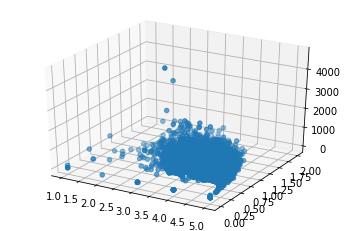

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()

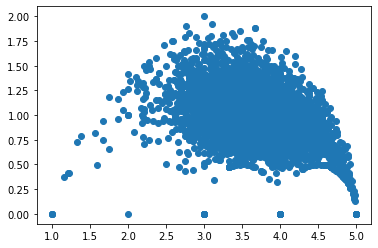

In [0]:
plt.scatter(x,y)

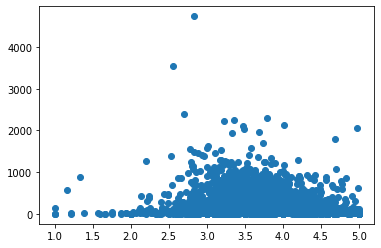

In [0]:
plt.scatter(x,z)

In [0]:
mid_map = defaultdict(list)
# movie_ratings = []
for i in range(len(raw_df)):
    current = raw_df.iloc[i]
    mid = current[0]
    rating = current[2]
    if mid not in mid_map:
        mid_map[mid] = [[rating]]
    else:
        mid_map[mid][0].append(rating)

In [0]:
save_obj(mid_map, 'mid_map')

In [0]:
len(mid_map)

16142

In [0]:
mov_dict = mid_map.copy()

In [0]:
for mid in mov_dict:
    no_ratings = len(mov_dict[mid][0])
    mean_rating = np.mean(np.array(mov_dict[mid][0]))
    std_dev = np.std(np.array(mov_dict[mid][0]))
    mov_dict[mid][0] = mean_rating
    mov_dict[mid].append(std_dev)
    mov_dict[mid].append(no_ratings)

In [0]:
mx, my, mz = [], [], []
for i, mid in enumerate(mov_dict):
    mx.append(mov_dict[mid][0])
    my.append(mov_dict[mid][1])
    mz.append(mov_dict[mid][2])

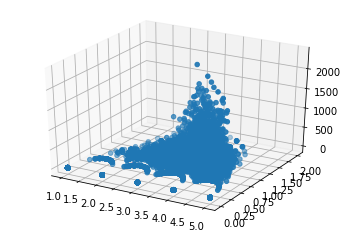

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mx, my, mz)
plt.show()

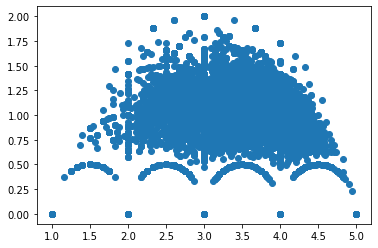

In [0]:
plt.scatter(mx, my)

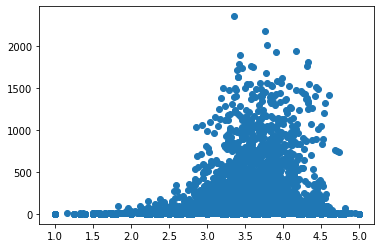

In [0]:
plt.scatter(mx, mz)

In [0]:
# tsne experiments
from sklearn.manifold import TSNE

In [0]:
TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
     n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', 
     init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)